# PAA Project, a.y. 2015/2016
## Average number of checks for Quicksort

Authors: Tommaso Papini (5537529), Gabriele Bani (5719258)


### Some initial imports

In [2]:
import numpy
from sympy import *
from sympy.abc import x, n, z, t, j, k

init_printing()

### Quicksort implementation with checks counting

In [3]:
def quick(v,l,r):
    #v is the array, l and r are the indexes of the quicksort (left and right)
    nc = 0; #nc is the number of checks made by the QuickSort Algorithm
    if r-l>=0:
        p = v[r]
        i = l-1
        j = r
        while i<j:
            i=i+1
            nc=nc+1
            while v[i]<p:
                i=i+1
                nc=nc+1
            j=j-1
            nc=nc+1
            while l<=j and p<v[j]:
                j=j-1
                nc=nc+1
            if i<j:
                a=v[i]
                v[i]=v[j]
                v[j]=a
        a=v[i]
        v[i]=p
        v[r]=a
        nc = nc + quick(v,l,i-1)
        nc = nc + quick(v,i+1,r)
    return nc

### Closed form to compute the average number of checks for Quicksort on an array of $n$ elements

In [4]:
def checks_quicksort(n):
    return 2*(n+1)*(harmonic(n+1).evalf()-1)

### A couple of examples

In [5]:
random_perm = numpy.random.permutation(20)
print "Random array: %s" % (random_perm)
checks = quick(random_perm,0,19)
print "Array after Quicksort: %s" % (random_perm)
print "Quicksort count: %.5f; closed-form: %.5f" % (checks, checks_quicksort(20))

Random array: [ 0 15 17 14  5  8 11 13  2  1 18  6 12 16 19  7  4  3  9 10]
Array after Quicksort: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Quicksort count: 119.00000; closed-form: 111.10507


In [6]:
random_perm = numpy.random.permutation(4)
print "Random array: %s" % (random_perm)
checks = quick(random_perm,0,3)
print "Array after Quicksort: %s" % (random_perm)
print "Quicksort count: %.5f; closed-form: %.5f" % (checks, checks_quicksort(4))

Random array: [1 0 3 2]
Array after Quicksort: [0 1 2 3]
Quicksort count: 12.00000; closed-form: 12.83333


### Main recurrence

#### Python version

In [7]:
def C_py(n):
    if n == 0:
        return 0
    else:
        Cn = 0.0
        for k in range(0, n):
            Cn += C_py(k)
        return n+1+(2.0/n)*Cn
random_perm = numpy.random.permutation(20)
print "Quicksort count: %.5f; closed-form: %.5f; recurrence: %.5f" % (quick(random_perm,0,19), checks_quicksort(20), C_py(20))

Quicksort count: 110.00000; closed-form: 111.10507; recurrence: 111.10507


#### sympy version

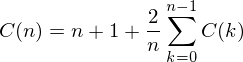

In [8]:
C_fun = Function('C')
base_rec = Eq(C_fun(n), n+1+(2/n)*Sum(C_fun(k), (k, 0, n-1)))
base_rec

#### Are we lucky?

In [9]:
print rsolve(base_rec, C_fun(n), {C_fun(0):0})

None


Nope... :(

### Recurrence solving (difference method)

#### Auxiliary function to apply the same operation to a number and two sided of an Eq

In [10]:
def do_both(eq, n, op):
    return Eq(op(eq.lhs, n), op(eq.rhs, n))

#### Multiply by n both sides

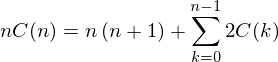

In [11]:
base_rec2 = do_both(base_rec, n, lambda x,y: x*y).simplify()
base_rec2

#### The above is valid forall $n$, so it's valid for $n-1$ as well

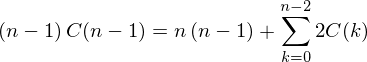

In [12]:
base_rec2_prev = base_rec2.subs(n, n-1).simplify()
base_rec2_prev

#### Auxiliary function to apply an operation to two Eqs sidewise

In [13]:
def do_eqs(eq1, eq2, op):
    return Eq(op(eq1.lhs, eq2.lhs), op(eq1.rhs, eq2.rhs))

#### Application of the difference method

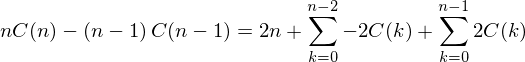

In [14]:
diff_rec = do_eqs(base_rec2, base_rec2_prev, lambda x,y: x-y).simplify()
diff_rec

#### Auxiliary function to extract the last term of a summation and substitute inside an Eq

In [15]:
def extract_last_term_subs(eq, old_sum):
    sum_args = old_sum.args
    f = sum_args[0]
    indexes = sum_args[1]
    new_sum = Sum(f, (indexes[0], indexes[1], indexes[2]-1)) + f.subs(indexes[0], indexes[2])
    return eq.subs(old_sum, new_sum)

#### Extract term $n-1$ and simplify summations

In [16]:
diff_rec2 = extract_last_term_subs(diff_rec, Sum(2*C_fun(k), (k, 0, n-1))).simplify().doit()
diff_rec2

#### Move $(n-1)C(n-1)$ to the other side and group by $C(n-1)$

In [17]:
new_rec = do_both(diff_rec2, (n-1)*C_fun(n-1), lambda x,y: x+y).simplify().factor(C_fun(n-1))
new_rec

#### Divide both sides by $n(n-1)$

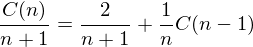

In [18]:
div_rec  = apart(do_both(new_rec, n*(n+1), lambda x,y: x/y), C_fun(n-1))
div_rec